# Data Science microproject

## Import Libraries

In [72]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import re
from wordcloud import WordCloud, STOPWORDS
import pickle

## Load the dataset

In [73]:

warnings.filterwarnings('ignore')


df = pd.read_csv('twitter_sentiment.csv', header=None, index_col=[0])
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


## Overview of the data

In [74]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


,sentiment,text
count,75682,74996
unique,4,69972
top,Negative,It is not the first time that the EU Commissio...
freq,22808,172


In [75]:
df['sentiment'].value_counts()

sentiment
Negative      22808
Positive      21109
Neutral       18603
Irrelevant    13162
Name: count, dtype: int64

## Missing values

In [76]:
df.isnull().sum()

df.dropna(inplace=True)

df = df[df['text'].apply(len)>1]

In [78]:
def _get_wordcounts(x):
	length = len(str(x).split())
	return length

def _get_charcounts(x):
	s = x.split()
	x = ''.join(s)
	return len(x)

def _get_avg_wordlength(x):
	count = _get_charcounts(x)/_get_wordcounts(x)
	return count

def _get_stopwords_counts(x):
	l = len([t for t in x.split() if t in stopwords])
	return l

def _get_hashtag_counts(x):
	l = len([t for t in x.split() if t.startswith('#')])
	return l

def _get_mentions_counts(x):
	l = len([t for t in x.split() if t.startswith('@')])
	return l

def _get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

def _get_uppercase_counts(x):
	return len([t for t in x.split() if t.isupper()])

def get_basic_features(df):
	if type(df) == pd.core.frame.DataFrame:
		df['char_counts'] = df['text'].apply(lambda x: _get_charcounts(x))
		df['word_counts'] = df['text'].apply(lambda x: _get_wordcounts(x))
		df['avg_wordlength'] = df['text'].apply(lambda x: _get_avg_wordlength(x))
		df['stopwords_counts'] = df['text'].apply(lambda x: _get_stopwords_counts(x))
		df['hashtag_counts'] = df['text'].apply(lambda x: _get_hashtag_counts(x))
		df['mentions_counts'] = df['text'].apply(lambda x: _get_mentions_counts(x))
		df['digits_counts'] = df['text'].apply(lambda x: _get_digit_counts(x))
		df['uppercase_counts'] = df['text'].apply(lambda x: _get_uppercase_counts(x))
	else:
		print('ERROR: This function takes only Pandas DataFrame')
		
	return df

In [79]:

# basic feature extraction | 

df = get_basic_features(df)

In [80]:
df.columns  

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

## Exploratory Data analysis

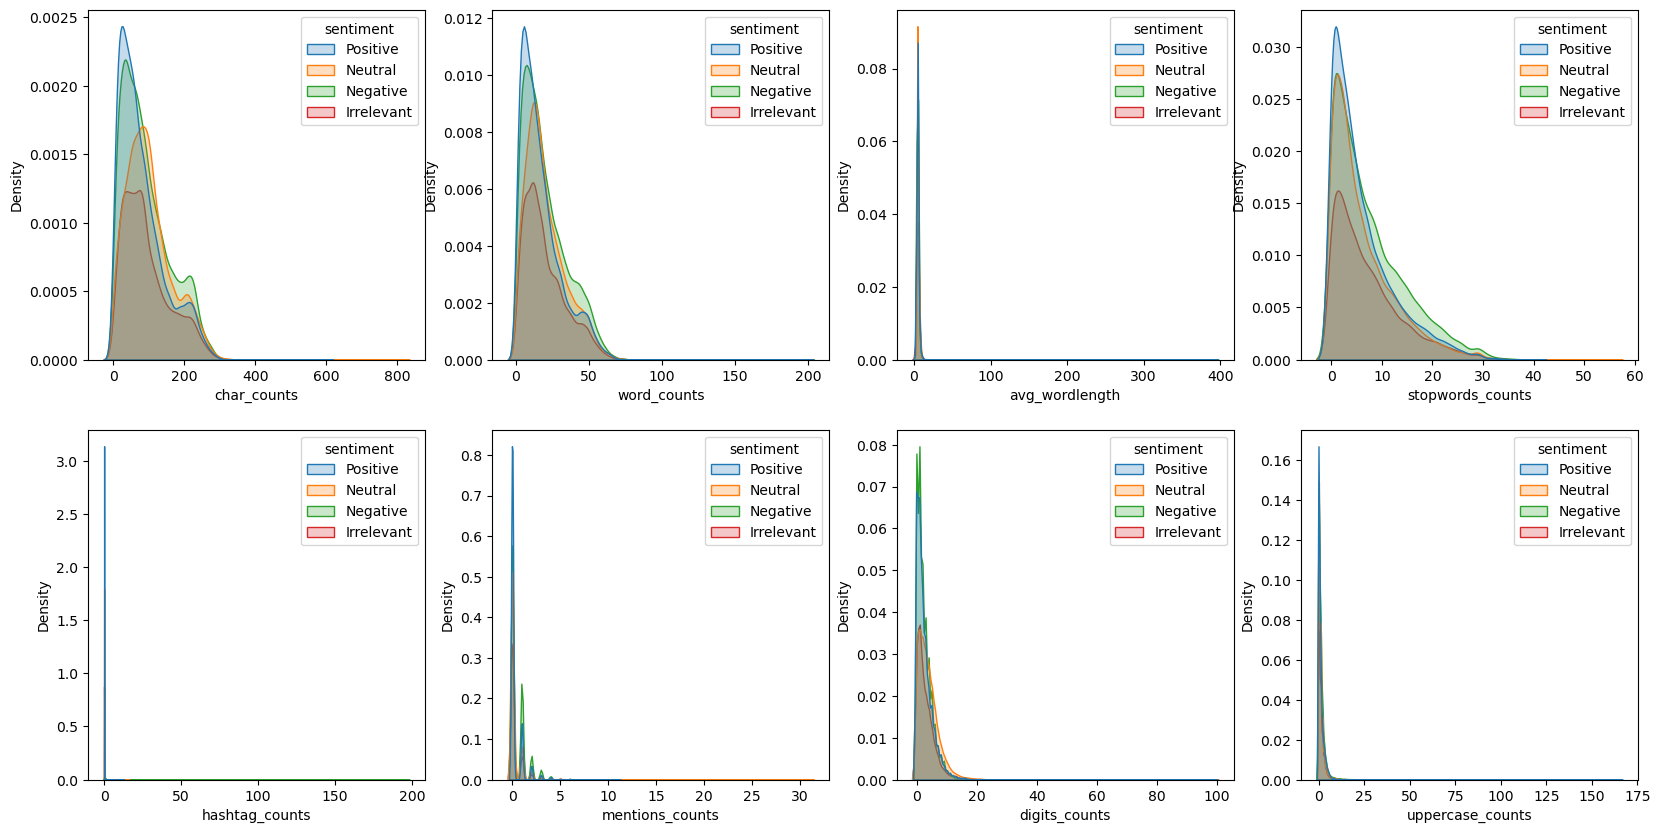

In [81]:
# Data Visualization

# plot 2x4 grid histogram for each numerical feature
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.subplot(2,4, num_cols.get_loc(col)+1)

    # use sentiment as hue to see the distribution of each numerical feature
    # sns.distplot(df[col], label=col, color='red')
    # sns.histplot(x=col, hue='sentiment', data=df, color='green', bins=100, kde=True)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=True)



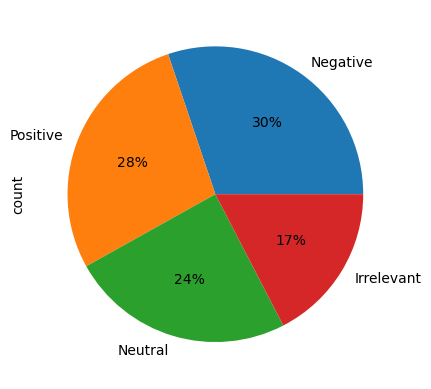

In [82]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

# word cloud


stopwords = set(STOPWORDS)

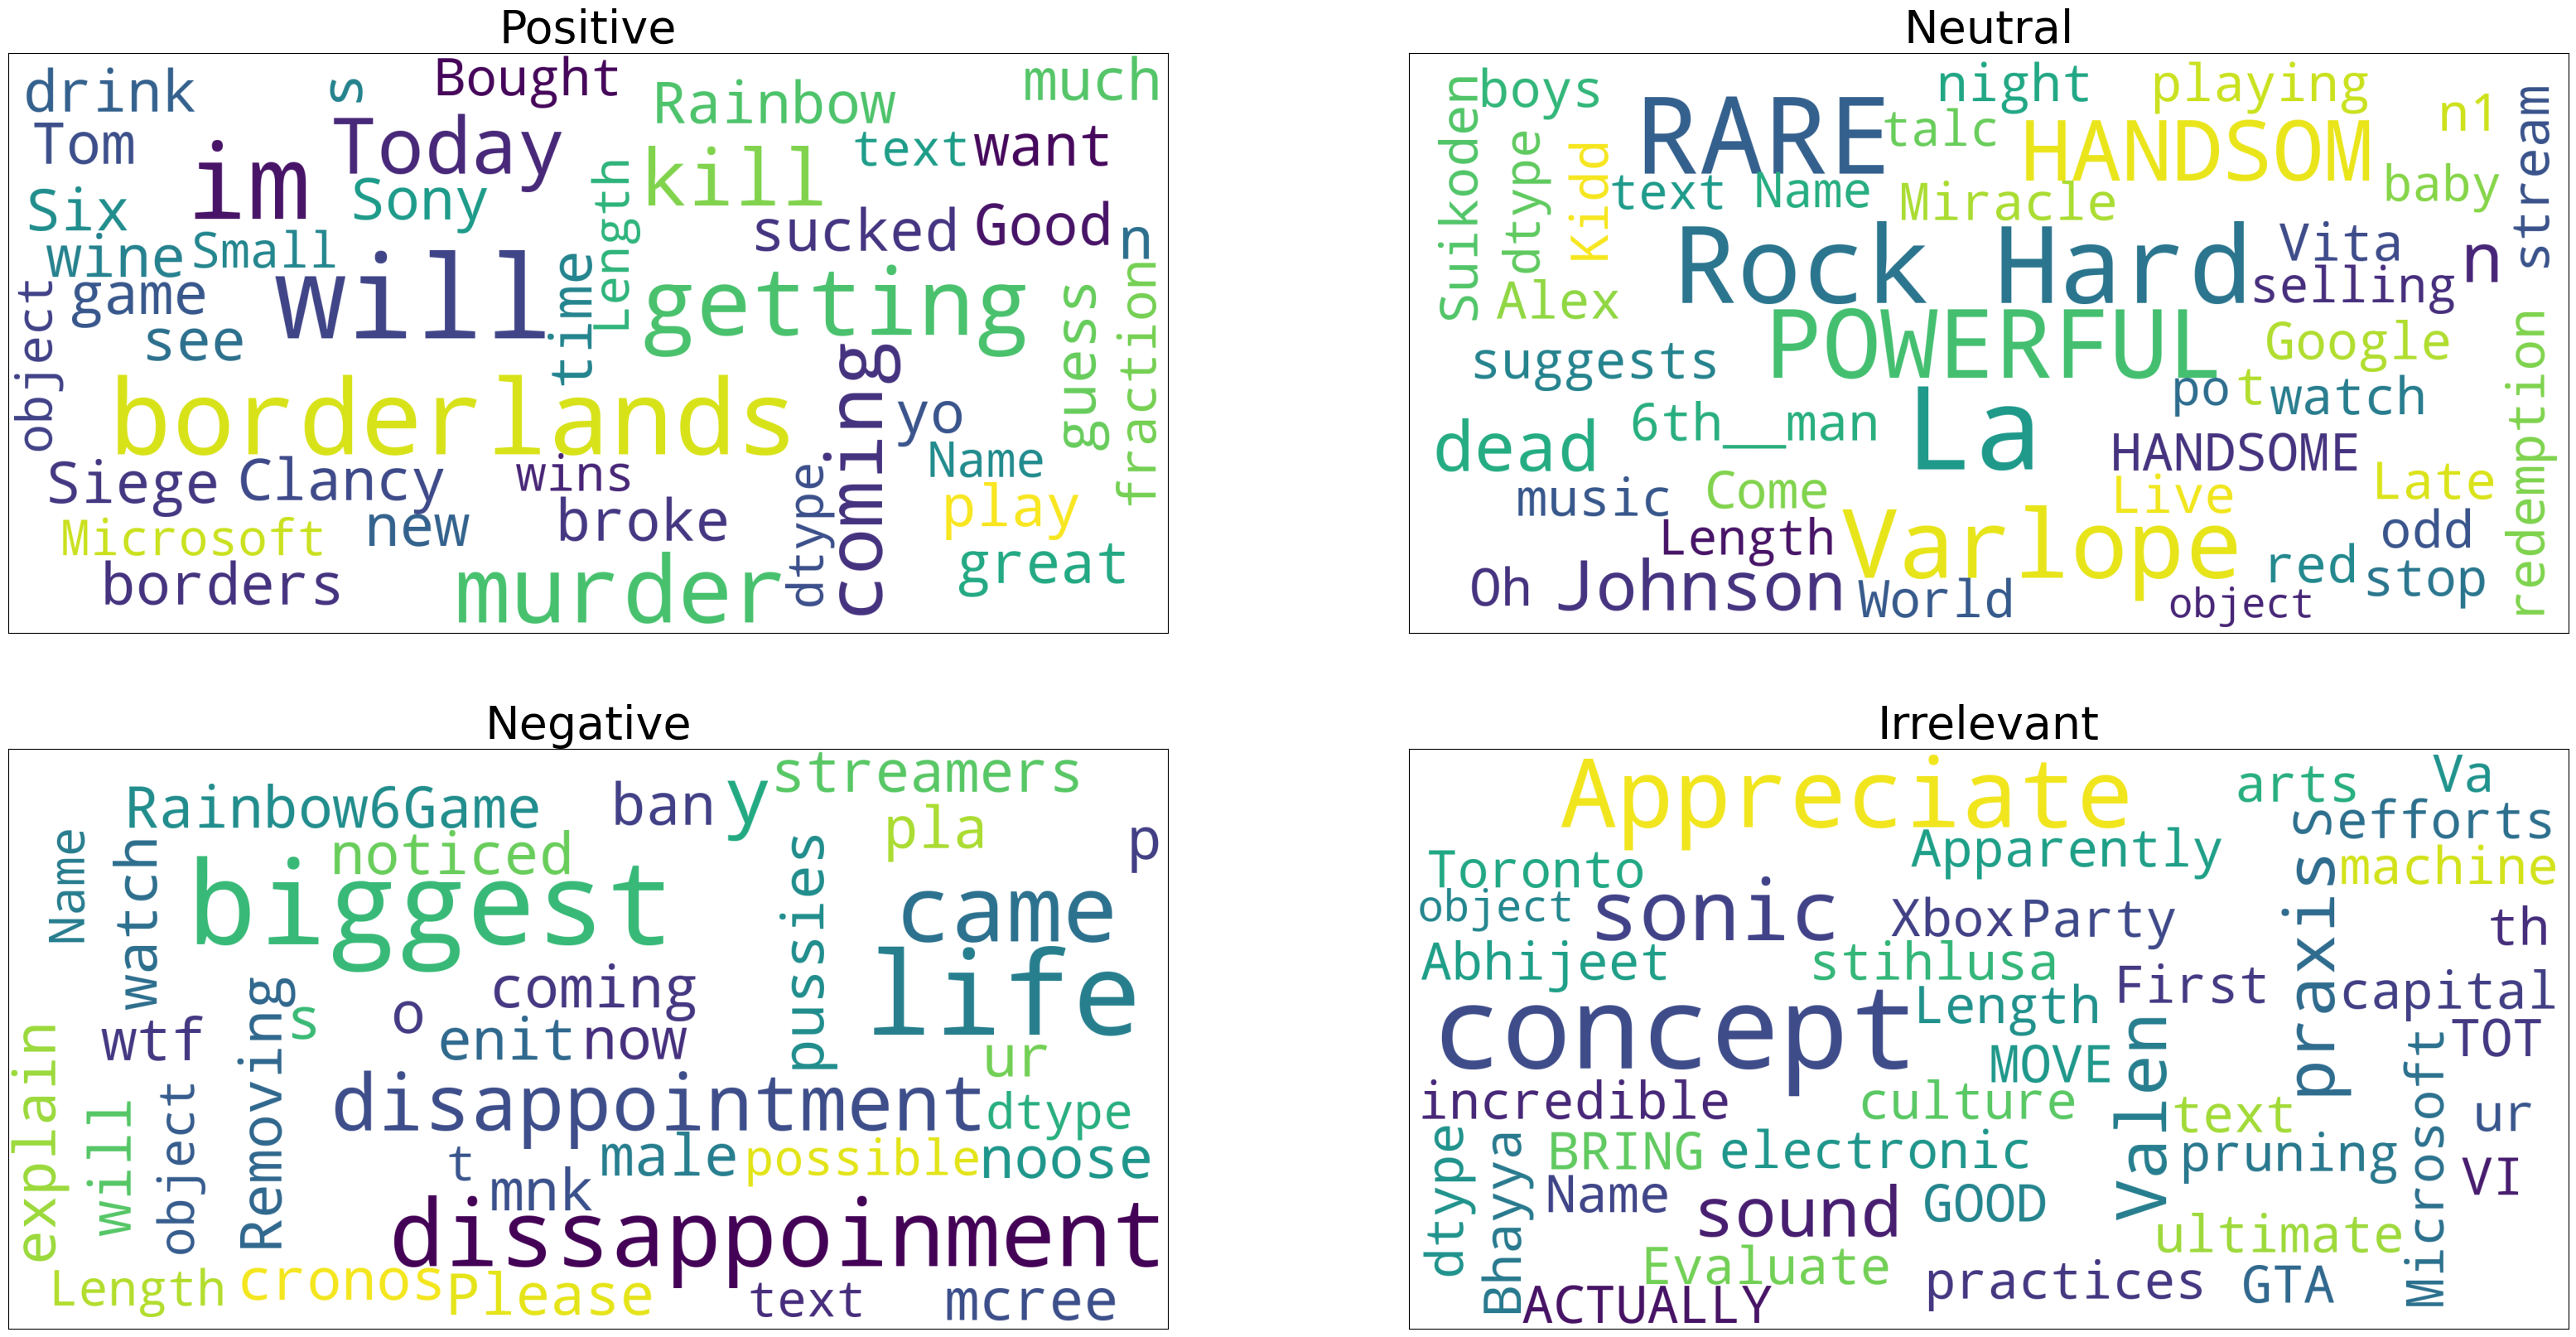

<Figure size 640x480 with 0 Axes>

In [83]:
# plot 2x2 grid word cloud for each sentiment
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)
    
plt.show()
plt.tight_layout()


## Data Preparation

In [84]:
def remove_urls(x):
	return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

def remove_rt(x):
	return re.sub(r'\brt\b', '', x).strip()

In [86]:
# Data Cleaning
# lowercase, remove url, html, punctuations, retweet

df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: remove_urls(x))
df['text'] = df['text'].apply(lambda x: remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: remove_rt(x))

In [87]:
# train test split


X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [50]:
X_train.shape, X_test.shape

((59717,), (14930,))

## Model Building

In [88]:
# model building
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(stopwords))), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(X_train, y_train)

# evaluation
from sklearn.metrics import accuracy_score

predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9117213663764233


In [40]:
# save model
pickle.dump(clf, open('twitter_sentiment.pkl', 'wb'))

In [41]:
X_test.tolist()[:20]

['add 4 callofduty and in roguecompany now teams o and everyone plays under play _ pso2 or ghostrecon i am also one of the best grovers in paladinsgame and best junkrat or mccree in overwatchleague dont forget best vulcan in smitegame i play destinythegame and fortnitegame',
 'tmobile you guys kids are really very slow in tuba star city az makes people go to google verizon',
 'i will make google top ranking high quality seo backlinks fiverrcom share nwewvp',
 'i know a guy whos tablet crashes today after 10 years he tried to fix it without google videos and plugging the tv into a different outlet no luck',
 'eamaddennfl movement is incredible',
 'internship manager',
 'bgs not in first by hearthstonebattlegrounds gameforcejphearthstonee3',
 'almost 2 years after launch and 3 cancelled season later bfv still now have game same in mp even though its fully functional in ghost campaign touche beyond every wire putting one nail in the coffin at a time',
 'so wait horses arthura poo hahaha s